# **MELANOMA DETECTION ASSIGNMENT USING CNN**

## **Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## **Importing Skin Cancer Data**


In [1]:
### Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [34]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Melanoma Data/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Melanoma Data/Test')

In [35]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

##**Create a dataset**

Define some parameters for the loader:

In [36]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [37]:
## Train dataset
## Note: use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [38]:
## Validation dataset here
## Note: use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [39]:
# Testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [40]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## **Visualize the data**


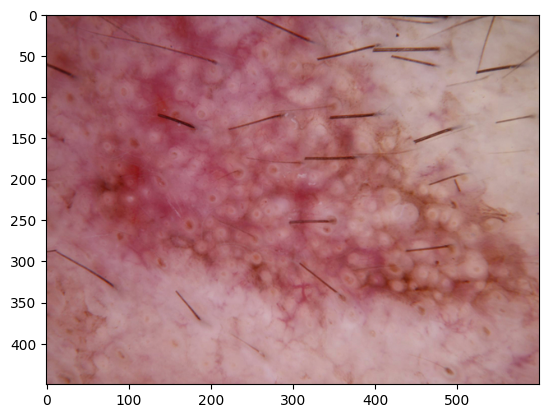

In [41]:
import matplotlib.pyplot as plt

image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)


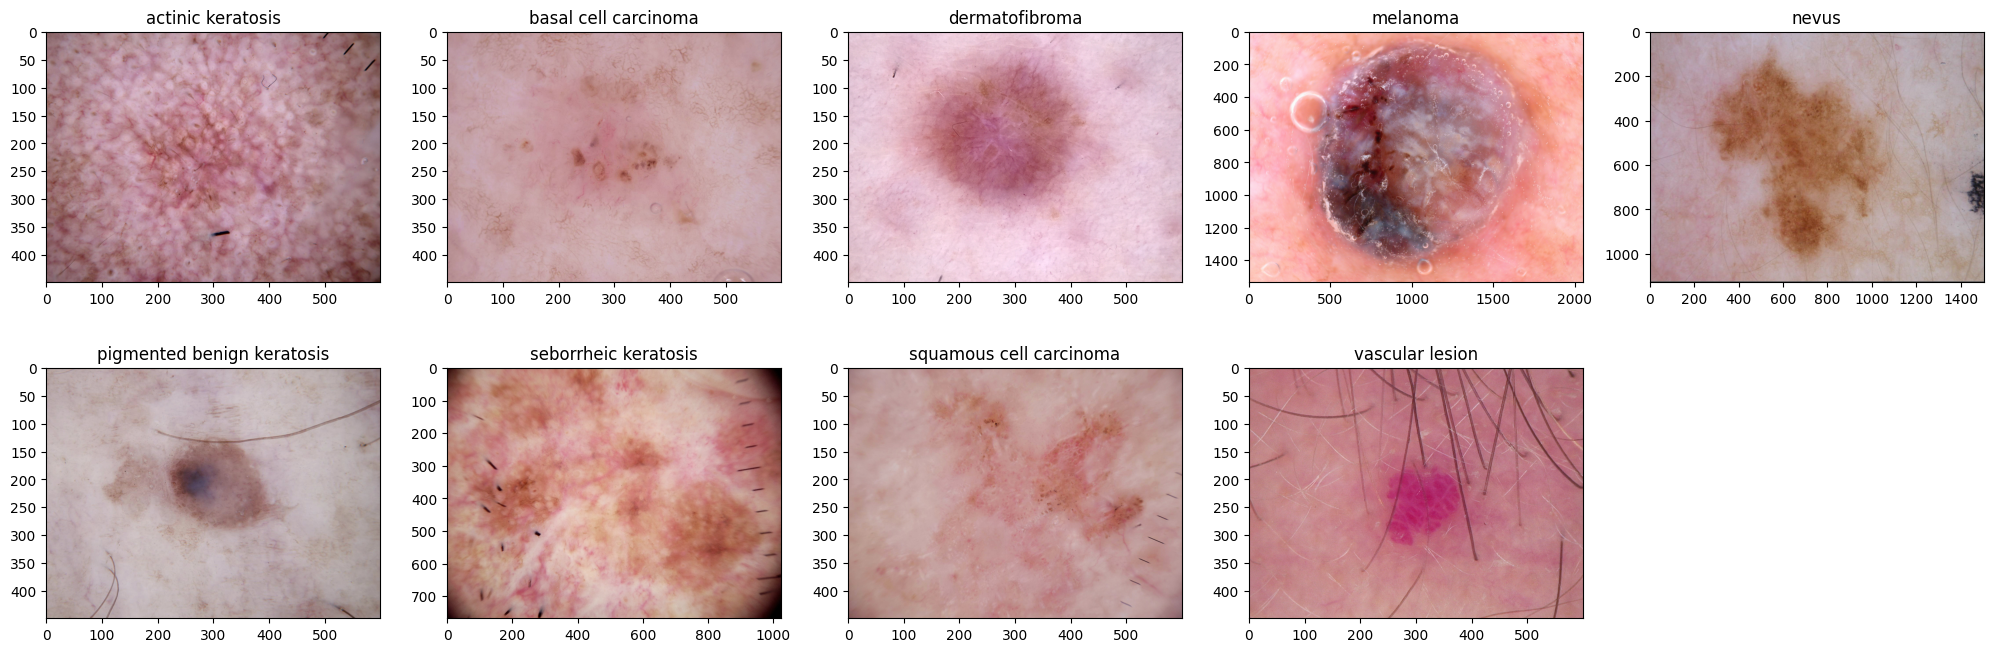

In [42]:
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **First CNN Model**
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [44]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [45]:
# compile the model
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 259200)           

In [46]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 152ms/step - loss: 3.4185 - accuracy: 0.2015 - val_loss: 1.9148 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 1.7148 - accuracy: 0.3906 - val_loss: 1.6241 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 4s 72ms/step - loss: 1.4981 - accuracy: 0.4827 - val_loss: 1.5607 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 4s 73ms/step - loss: 1.3496 - accuracy: 0.5273 - val_loss: 1.4234 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.1708 - accuracy: 0.5837 - val_loss: 1.3804 - val_accuracy: 0.5503
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.0463 - accuracy: 0.6378 - val_loss: 1.4238 - val_accuracy: 0.5548
Epoch 7/20
56/56 [==============================] - 4s 73ms/step - loss: 0.9332 - accuracy: 0.6674 - val_loss: 1.6349 - val_accuracy: 0.5302
Epoch 8/20


In [47]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

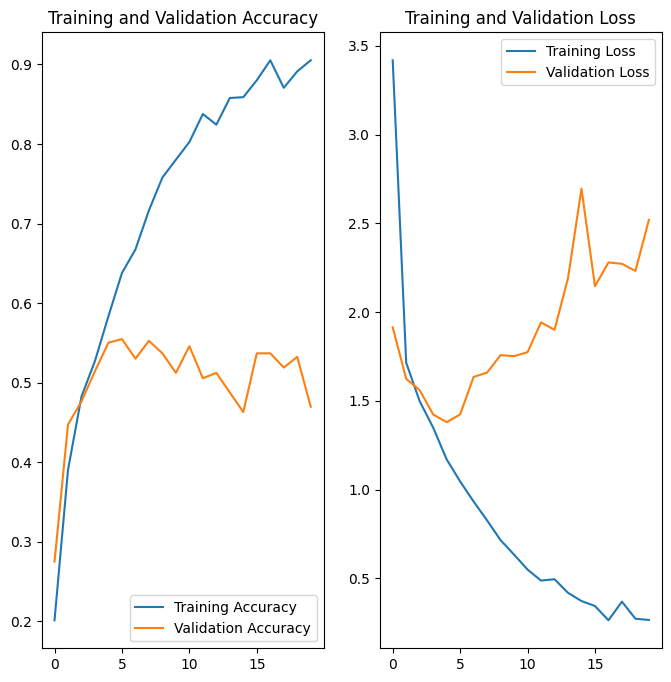

In [48]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

#### **Observations :**
        
- The model's training accuracy displays a linear increase over time, whereas the validation accuracy plateaus at 50% accuracy during the training process.

- As the training epochs progress, the training loss decreases, however, the validation loss exhibits an opposing trend and increases.

- The visual representation of the model's performance indicates a substantial discrepancy between the training accuracy and validation accuracy, achieving a validation accuracy of approximately 50%.

- The noticeable difference between the training accuracy and validation accuracy is a clear indication of overfitting, indicating that the model may not generalize well to unseen data.

## **Data Augmentation**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [49]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

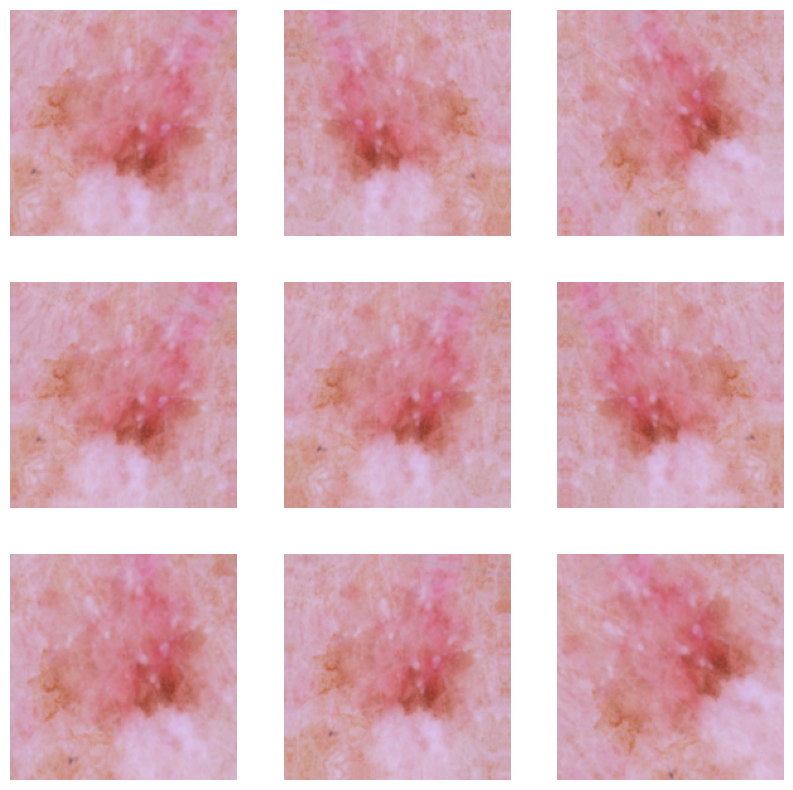

In [50]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## **Model Building & training on the augmented data :**

- Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
- Choosing an appropriate optimiser and loss function for model training
- Training the model for ~20 epochs
- Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.


In [51]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))
# Compiling the model



In [52]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [53]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 79ms/step - loss: 3.1291 - accuracy: 0.2634 - val_loss: 1.8636 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 4s 76ms/step - loss: 1.6926 - accuracy: 0.4102 - val_loss: 1.5343 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5784 - accuracy: 0.4559 - val_loss: 1.4779 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.4421 - accuracy: 0.4916 - val_loss: 1.5233 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 4s 75ms/step - loss: 1.4330 - accuracy: 0.4972 - val_loss: 1.4237 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 1.3841 - accuracy: 0.5067 - val_loss: 1.4339 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 4s 76ms/step - loss: 1.3433 - accuracy: 0.5195 - val_loss: 1.5333 - val_accuracy: 0.5056
Epoch 8/20
56

### Visualizing the results

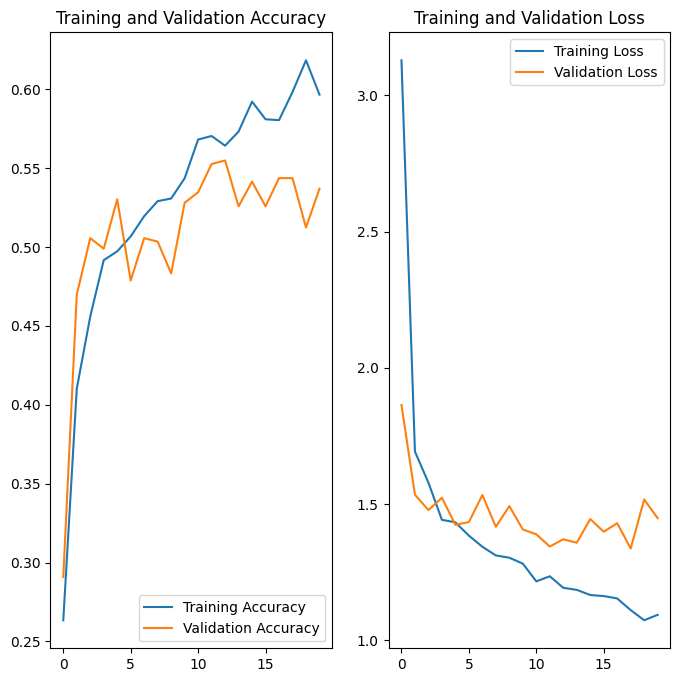

In [54]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Inferences:**
1. As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
2. As the training loss decreases with epochs the validation loss decreases and stalls.
3. The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.

**We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

## **Class distribution:**
Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [55]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Melanoma Data/Train/act...,actinic keratosis
1,/content/drive/MyDrive/Melanoma Data/Train/act...,actinic keratosis
2,/content/drive/MyDrive/Melanoma Data/Train/act...,actinic keratosis
3,/content/drive/MyDrive/Melanoma Data/Train/act...,actinic keratosis
4,/content/drive/MyDrive/Melanoma Data/Train/act...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Melanoma Data/Train/vas...,vascular lesion
2235,/content/drive/MyDrive/Melanoma Data/Train/vas...,vascular lesion
2236,/content/drive/MyDrive/Melanoma Data/Train/vas...,vascular lesion
2237,/content/drive/MyDrive/Melanoma Data/Train/vas...,vascular lesion


In [56]:
## Inspecting the distribution of classes in the data
original_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

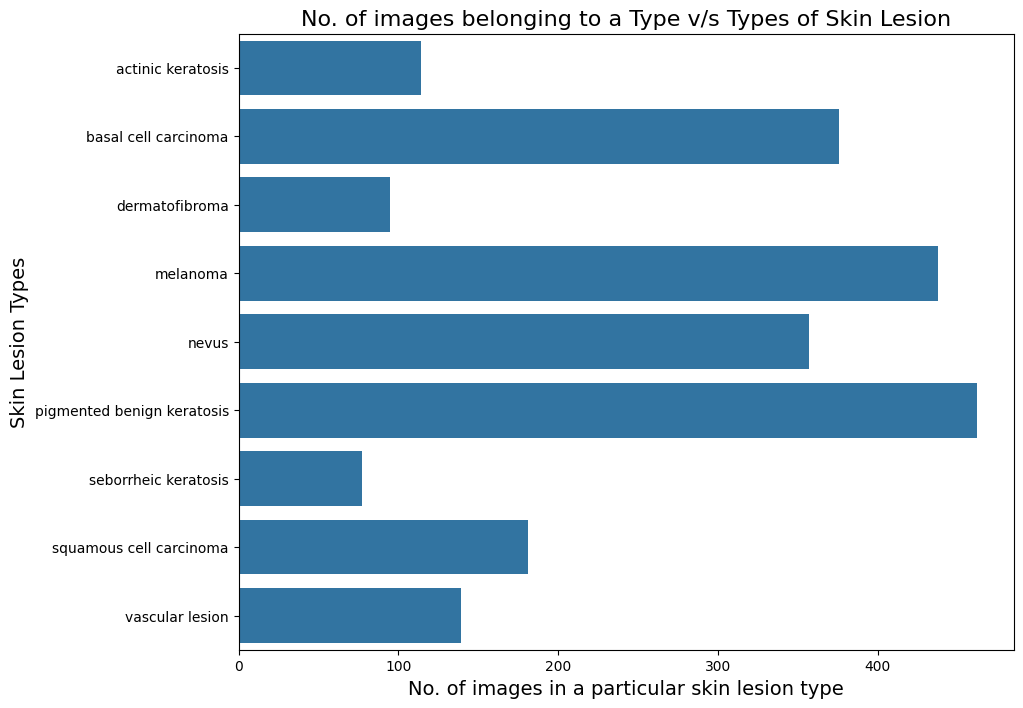

In [58]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data= original_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

**Findings :**
1. Which class has the least number of samples?
- Seborrheic keratosis with 77 samples
2. Which classes dominate the data in terms proportionate number of samples?
- Pigmented benign keratosis with 462 samples


## **Handling class imbalances:**
Rectifing class imbalances present in the training dataset with Augmentor library.

You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [59]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [60]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AC34C62FB20>: 100%|██████████| 500/500 [00:25<00:00, 19.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC47B6512A0>: 100%|██████████| 500/500 [00:23<00:00, 21.58 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AC34C5FBC10>: 100%|██████████| 500/500 [00:19<00:00, 25.65 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7AC47B651480>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1007x711 at 0x7AC34C6ADB40>: 100%|██████████| 500/500 [01:36<00:00,  5.20 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC47D88DFF0>: 100%|██████████| 500/500 [00:20<00:00, 24.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AC34C7DD540>: 100%|██████████| 500/500 [00:37<00:00, 13.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC47D848520>: 100%|██████████| 500/500 [00:18<00:00, 27.15 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AC47DEE94B0>: 100%|██████████| 500/500 [00:20<00:00, 24.10 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [61]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [62]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Melanoma Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031597.jpg_9fb365b7-cc52-41e1-86dc-01804ab45640.jpg',
 '/content/drive/MyDrive/Melanoma Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027526.jpg_d8d879fa-e01d-46d3-9ecb-545b38db7cf4.jpg',
 '/content/drive/MyDrive/Melanoma Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024590.jpg_33ce5e5e-a3ef-4a61-bbee-a5fe324ed797.jpg',
 '/content/drive/MyDrive/Melanoma Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029524.jpg_757fd6ac-534d-4961-99a1-c5c9091d6057.jpg',
 '/content/drive/MyDrive/Melanoma Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029680.jpg_7ed85025-d549-4668-9d74-5788285129e8.jpg',
 '/content/drive/MyDrive/Melanoma Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028095.jpg_dbbe8701-eb23-4185-b61f-0d7847b7254a.jpg',
 '/content/drive/MyDri

In [63]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [66]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [70]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [71]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Creating new dataset**

In [72]:
batch_size = 32
img_height = 180
img_width = 180

In [74]:
# Create a training dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               subset='training')


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [75]:
# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## **Model Building & training on the rectified class imbalance data :**
- Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
- Choosing an appropriate optimiser and loss function for model training
- Training the model for ~30 epochs
- Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [77]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [78]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [79]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 55s 295ms/step - loss: 2.7576 - accuracy: 0.2098 - val_loss: 1.7646 - val_accuracy: 0.3682
Epoch 2/30
169/169 [==============================] - 47s 271ms/step - loss: 1.6699 - accuracy: 0.3574 - val_loss: 1.5298 - val_accuracy: 0.4202
Epoch 3/30
169/169 [==============================] - 47s 268ms/step - loss: 1.5105 - accuracy: 0.4173 - val_loss: 1.3881 - val_accuracy: 0.4566
Epoch 4/30
169/169 [==============================] - 45s 260ms/step - loss: 1.4224 - accuracy: 0.4635 - val_loss: 1.3494 - val_accuracy: 0.4974
Epoch 5/30
169/169 [==============================] - 45s 256ms/step - loss: 1.3489 - accuracy: 0.4841 - val_loss: 1.3927 - val_accuracy: 0.4566
Epoch 6/30
169/169 [==============================] - 46s 262ms/step - loss: 1.2849 - accuracy: 0.5174 - val_loss: 1.2398 - val_accuracy: 0.5382
Epoch 7/30
169/169 [==============================] - 45s 260ms/step - loss: 1.2040 - accuracy: 0.5410 - val_loss: 1.1470 - val_ac

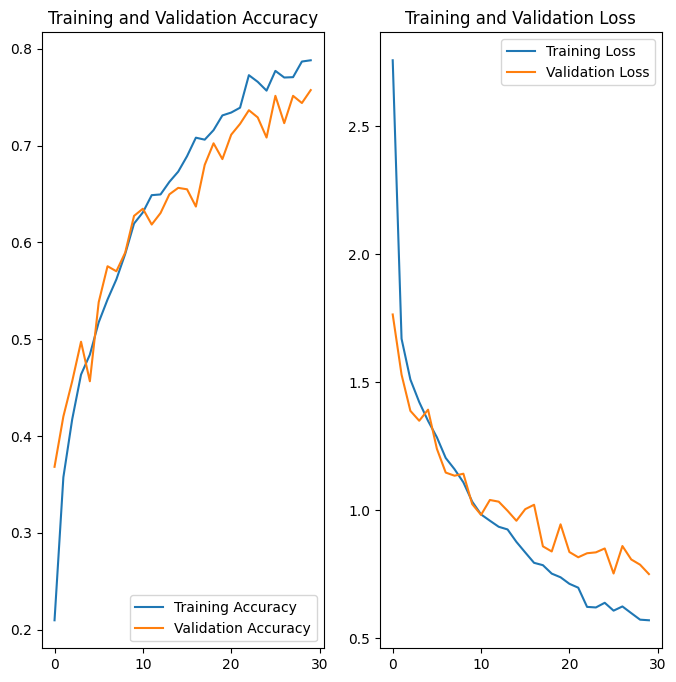

In [80]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

#### **Inference:**
- As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
- As the training loss decreases with epochs the validation loss also decreases.
- The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 75% accuracy on the validation set.
- The difference in accuracy between training and validation accuracy is very less



**Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 75%.**

## **Model Prediction**

Predict using test data

1/1 [==============================] - 0s 450ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


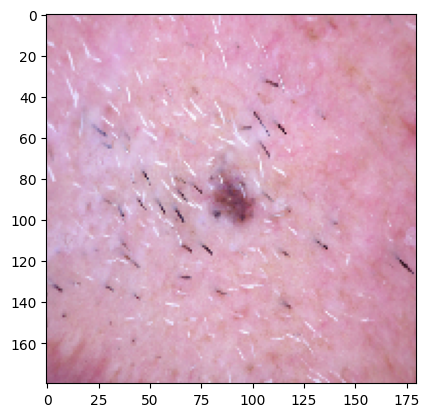

In [82]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)